## Importing Libraries

In [98]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

## Important Functions

Reference From the https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [56]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Read Train Data
1. Use pandas library to read data     
2. making parse_date and squeeze equal to true, so that we can extract data in timeseries format    
3. Drop Id from the data set which is not required   

In [21]:
trainData = pd.read_csv('../data/train_csv.csv', header = 0, index_col =1, parse_dates = True, squeeze = True)
trainData.drop(['id'],axis=1,inplace = True)
trainData.head()

,feature
time,
2019-03-19 00:00:00,237.97
2019-03-19 00:00:10,57.93
2019-03-19 00:00:20,90.53
2019-03-19 00:00:30,260.75
2019-03-19 00:00:40,49.70


## Visualize the train Data

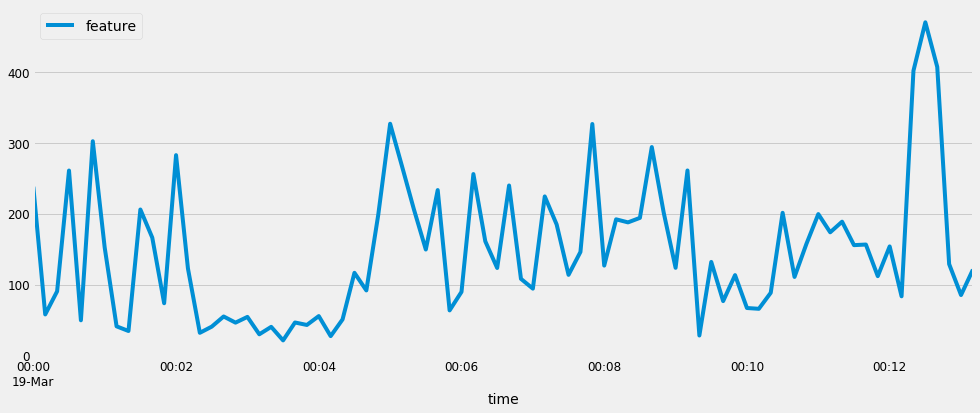

In [22]:
trainData.plot(figsize=(15, 6))
plt.show()

## Time Series Decomposition
We are decomposing the timeseries data into distinct components like Trend, Sesonal, Residual and Observed

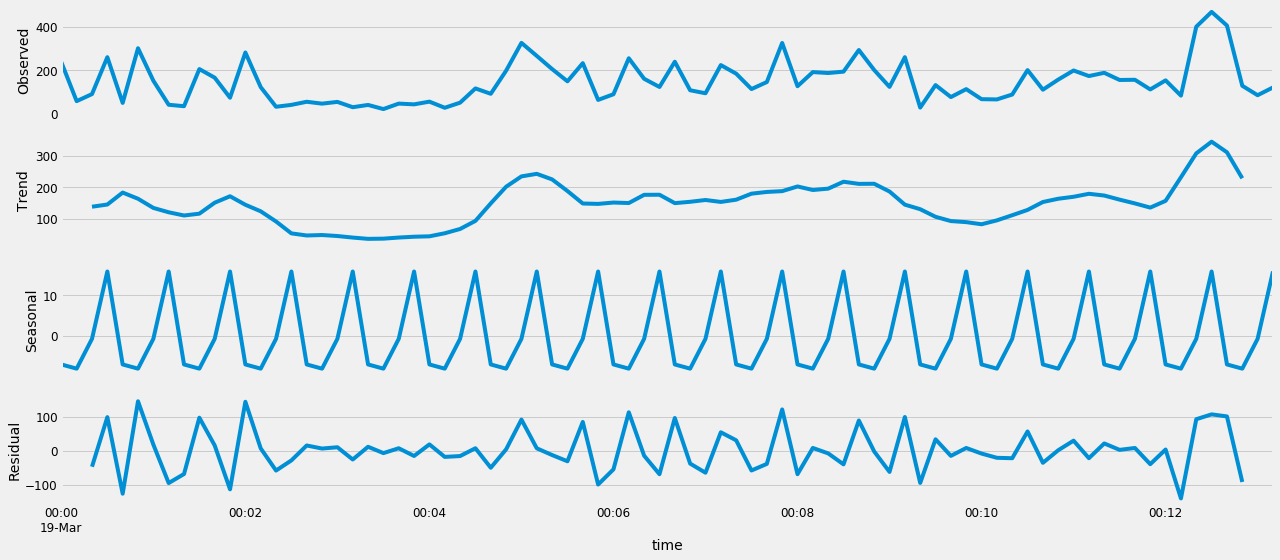

In [23]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(trainData, model='additive',freq=4)
fig = decomposition.plot()
plt.show()

### Applying the Dicker-Fuller Test
This is the statistcal test to check the stationarity of the series.The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.


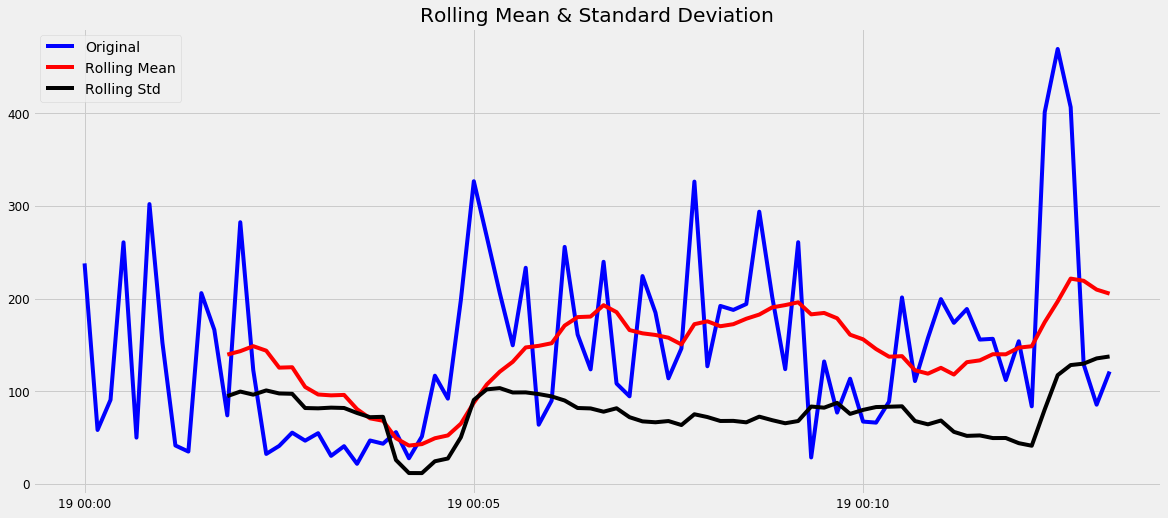

Results of Dickey-Fuller Test:
Test Statistic                -5.945866e+00
p-value                        2.205049e-07
#Lags Used                     0.000000e+00
Number of Observations Used    7.900000e+01
Critical Value (1%)           -3.515977e+00
Critical Value (5%)           -2.898886e+00
Critical Value (10%)          -2.586694e+00
dtype: float64


In [66]:
test_stationarity(trainData.feature)

Since p-value > 0.05. Null Hypothesis cannot be rejected.

## How to make time series as stationary:
There are two ways:    
1. Remove Trend in the series
2. Remove Sesonality from the series

After seeing our graph we found there is not much trend, but still we can apply log transformation to overcome the higher values

In [67]:
trainDataLog = np.log(trainData.feature)

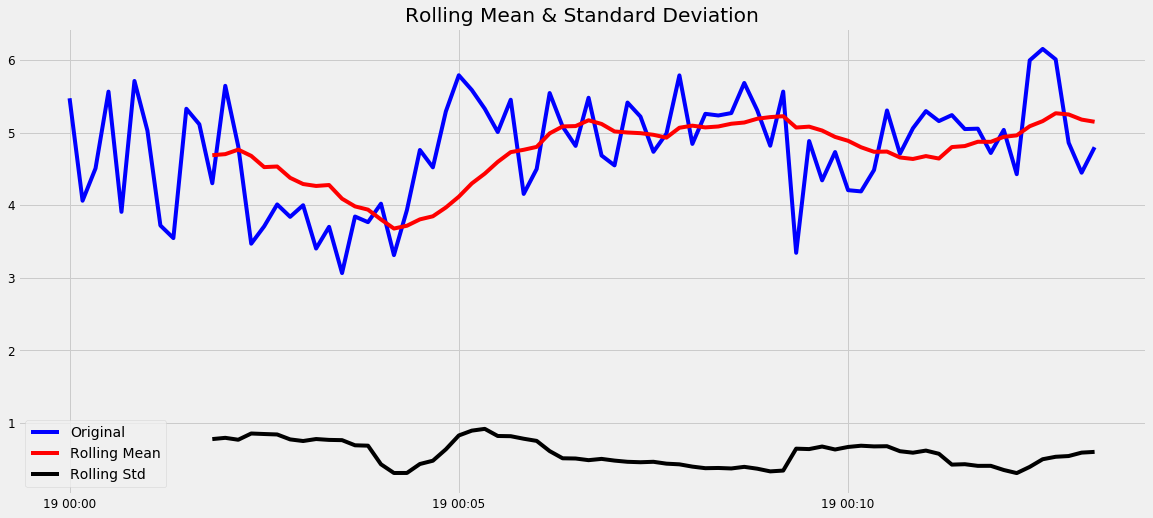

Results of Dickey-Fuller Test:
Test Statistic                 -3.777754
p-value                         0.003143
#Lags Used                      1.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


In [68]:
test_stationarity(trainDataLog)

Hence, p value is less than <0.003 but there is no much difference between the test statistic and Critical Value (1%)

## Removing Sesonality also from the series

Using the differencing techniques, to bring stationarity in the series data

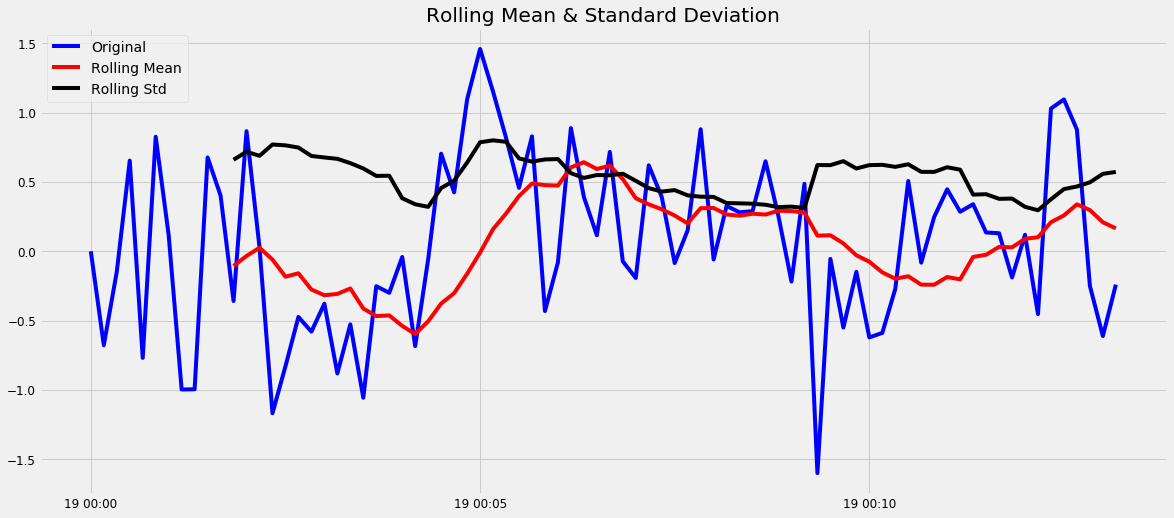

Results of Dickey-Fuller Test:
Test Statistic                 -4.407782
p-value                         0.000288
#Lags Used                      1.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


In [77]:
expwightedAverage = trainDataLog.ewm(12).mean()
trainDataLogEwmDiff = trainDataLog - expwightedAverage
test_stationarity(trainDataLogEwmDiff)

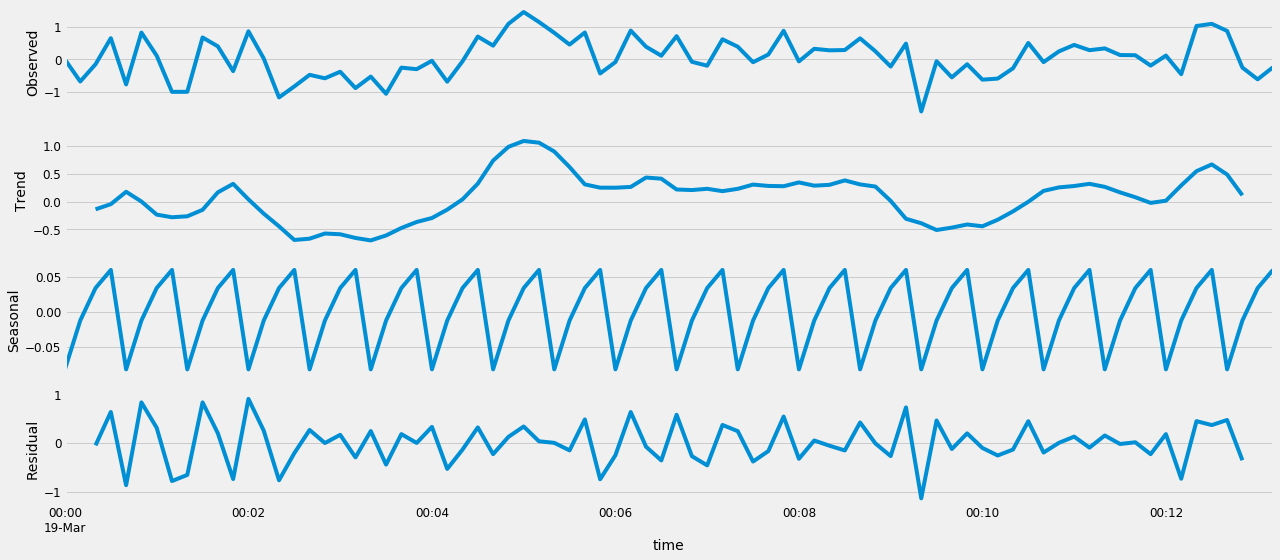

In [78]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(trainDataLogEwmDiff, model='additive',freq=4)
fig = decomposition.plot()
plt.show()

## Applying ARIMA Model

In [109]:
trainDataLogEwmDiff

time
2019-03-19 00:00:00    0.000000
2019-03-19 00:00:10   -0.678196
2019-03-19 00:00:20   -0.148241
2019-03-19 00:00:30    0.654243
2019-03-19 00:00:40   -0.769316
                         ...   
2019-03-19 00:12:30    1.095622
2019-03-19 00:12:40    0.878414
2019-03-19 00:12:50   -0.249900
2019-03-19 00:13:00   -0.611977
2019-03-19 00:13:10   -0.241015
Name: feature, Length: 80, dtype: float64

### Finding the P,D,Q Vakue for the ARIMA

In [110]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [111]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainDataLogEwmDiff,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:150.9691276550937
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:124.93615665297274
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:183.85865531244409
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:126.0982833371707
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:128.84734262523799
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:126.93498298617413
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:136.30971445671335
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:131.8163804881937
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:142.99662565413954
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:116.14148282809094
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:173.63890220668458
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:119.72019066468005
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:120.35429570385458
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:118.12107553401657
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:129.71038881773248
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:124.3030665682559
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:169.39227405881968
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:129.80023871459

From above we found that ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:108.27493996543797 have minimun AIC Value

In [112]:
model = sm.tsa.statespace.SARIMAX(trainFeatureDataDiff,
                                order=(0, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

In [113]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1.54e+04  -6.51e-05      1.000   -3.01e+04    3.01e+04
ma.S.L12      -0.1307      0.183     -0.714      0.475      -0.490       0.228
sigma2         0.2930   4504.641   6.51e-05      1.000   -8828.641    8829.228


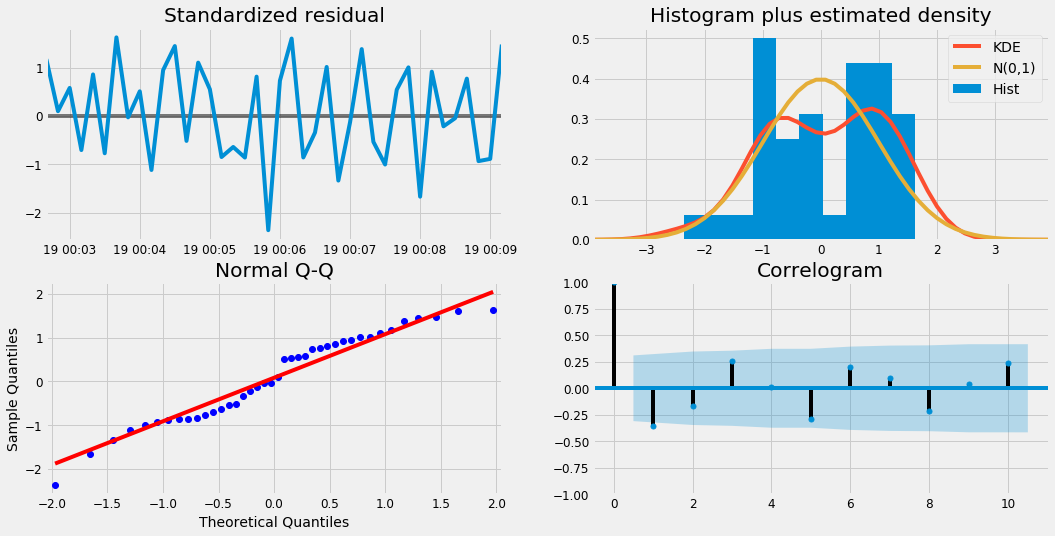

In [114]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### RMSE Error

In [130]:
pred=results.get_prediction()
pred.conf_int()

,lower feature,upper feature
2019-03-19 00:00:10,-2771.807649,2771.807649
2019-03-19 00:00:20,-1960.642468,1959.286075
2019-03-19 00:00:30,-1959.434604,1960.494514
2019-03-19 00:00:40,-1959.162075,1960.767043
2019-03-19 00:00:50,-1961.388117,1958.541001
2019-03-19 00:01:00,-1958.368706,1961.560411
2019-03-19 00:01:10,-1960.675077,1959.254041
2019-03-19 00:01:20,-1961.078101,1958.851017
2019-03-19 00:01:30,-1959.963086,1959.966032
2019-03-19 00:01:40,-1958.291362,1961.637756


In [132]:
y_forecasted = pred.predicted_mean

In [136]:
y_truth=trainFeatureDataDiff[:]

In [137]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.96


In [139]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.98


### Test Forecasting

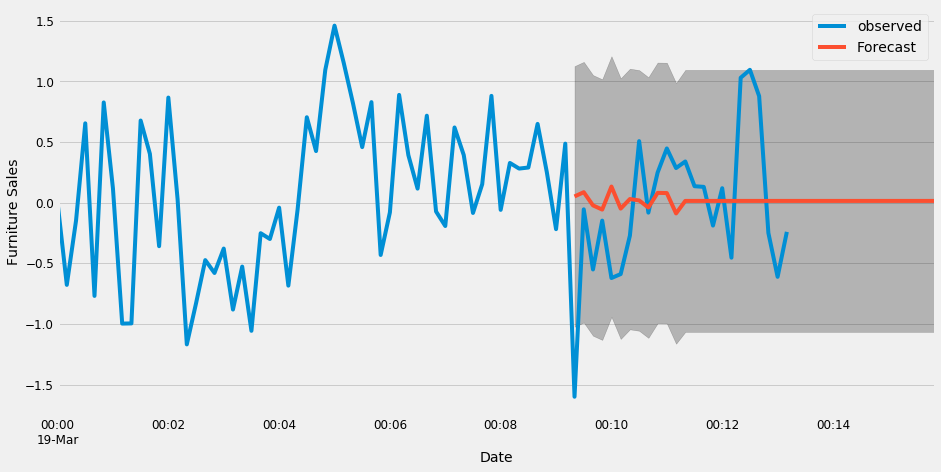

In [140]:
pred_uc = results.get_forecast(steps=40)
pred_ci = pred_uc.conf_int()
ax = trainDataLogEwmDiff.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()